In [1]:
import os
import urllib.request
import tarfile
import scipy.io
import shutil
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image  # Import the Image module from PIL

# Function to download and extract tar files
def download_and_extract(url, dest_path):
    if not os.path.exists(dest_path):
        os.makedirs(dest_path)
    file_name = os.path.join(dest_path, url.split('/')[-1])
    if not os.path.exists(file_name):
        urllib.request.urlretrieve(url, file_name)
    if file_name.endswith(".tgz") or file_name.endswith(".tar.gz"):
        with tarfile.open(file_name, "r:gz") as tar:
            tar.extractall(path=dest_path)

# URLs for the dataset files
base_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/"
files = ["102flowers.tgz", "imagelabels.mat", "setid.mat"]

# Destination directory
dest_dir = "data/flowers"

# Download and extract the dataset
for file in files:
    download_and_extract(base_url + file, dest_dir)

# Load labels
labels_path = os.path.join(dest_dir, "imagelabels.mat")
labels = scipy.io.loadmat(labels_path)["labels"][0]

# Load set IDs (train, val, test splits)
setid_path = os.path.join(dest_dir, "setid.mat")
setid = scipy.io.loadmat(setid_path)
train_ids = setid["trnid"][0]
val_ids = setid["valid"][0]
test_ids = setid["tstid"][0]

# Create directories for train, val, test sets
for split in ["train", "val", "test"]:
    split_dir = os.path.join(dest_dir, split)
    if not os.path.exists(split_dir):
        os.makedirs(split_dir)
    for i in range(1, 103):  # 102 classes
        class_dir = os.path.join(split_dir, str(i))
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

# Function to move images to their respective directories
def move_images(image_ids, split):
    split_dir = os.path.join(dest_dir, split)
    for img_id in tqdm(image_ids, desc=f"Moving {split} images"):
        class_id = labels[img_id - 1]  # Label indexing starts from 1
        src = os.path.join(dest_dir, "jpg", f"image_{img_id:05d}.jpg")
        dst = os.path.join(split_dir, str(class_id), f"image_{img_id:05d}.jpg")
        shutil.move(src, dst)

# Move images to the corresponding directories
move_images(train_ids, "train")
move_images(val_ids, "val")
move_images(test_ids, "test")

# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load dataset
train_dataset = datasets.ImageFolder(os.path.join(dest_dir, "train"), data_transforms['train'])
val_dataset = datasets.ImageFolder(os.path.join(dest_dir, "val"), data_transforms['val'])
test_dataset = datasets.ImageFolder(os.path.join(dest_dir, "test"), data_transforms['test'])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
# Load labels
labels_path = os.path.join(dest_dir, "imagelabels.mat")
labels = scipy.io.loadmat(labels_path)["labels"][0]



Moving test images: 100%|██████████| 6149/6149 [00:28<00:00, 215.56it/s]


In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Data Augmentation
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = ImageFolder(root='data/flowers/test', transform=transform)
test_dataset = ImageFolder(root='data/flowers/train', transform=transform)

class ModifiedResNet101(nn.Module):
    def __init__(self, original_model):
        super(ModifiedResNet101, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(original_model.fc.in_features, 102)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Create WeightedRandomSampler for balanced sampling
labels = np.array([label for _, label in train_dataset])
class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
weights = 1. / class_sample_count
samples_weights = np.array([weights[t] for t in labels])
sampler = WeightedRandomSampler(samples_weights, len(samples_weights))

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the pretrained ResNet-101 model
model = models.resnet101(pretrained=True)




for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 102)
model = ModifiedResNet101(model)
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00009)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Training loop
def train(model, train_loader, criterion, optimizer, scheduler, epochs=60):
    model.train()
    loss_values = []
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        scheduler.step(running_loss)
        epoch_loss = running_loss / len(train_loader)
        loss_values.append(epoch_loss)
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')
    return loss_values


# Plotting the training loss
def plot_loss(loss_values):
    if loss_values==None:
        return
    plt.figure()
    plt.plot(loss_values, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.show()
    
# Evaluate the model
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy: {100 * correct / total}%')
    
model_load_path = 'resnet101_flowers.pth'
# Load the model weights
load_weights=True
loss_values=None
if load_weights:
    model.load_state_dict(torch.load(model_load_path))
else:
    # Train and evaluate the model
    loss_values = train(model, train_loader, criterion, optimizer, scheduler)
evaluate(model, test_loader)


C:\Users\Desk\anaconda3\envs\gpu3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Desk\anaconda3\envs\gpu3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy: 94.2156862745098%


In [94]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
evaluate(model,val_loader)

Accuracy: 97.6470588235294%


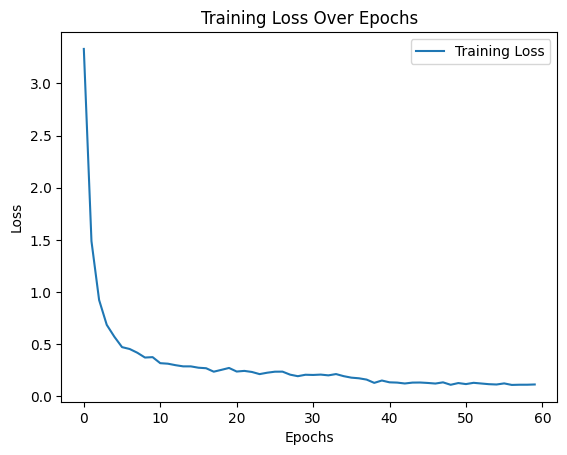

In [88]:
plot_loss(loss_values)

In [95]:
loss_values=evaluate(model, train_loader)

Accuracy: 97.9020979020979%


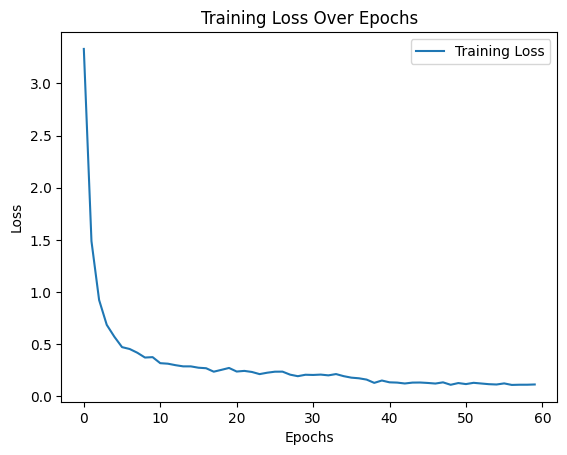

In [89]:
plot_loss(loss_values)

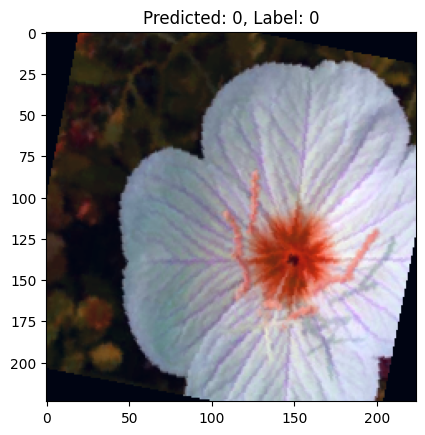

In [90]:
import matplotlib.pyplot as plt
import numpy as np

# Get predictions
def get_predictions(model, test_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(zip(inputs.cpu(), preds.cpu(), labels.cpu()))
    return predictions

# Display an image and prediction
def display_prediction(image_tensor, prediction, label):
    image = image_tensor.permute(1, 2, 0).numpy()
    image = np.clip(image * 0.229 + 0.485, 0, 1)  # Unnormalize
    plt.imshow(image)
    plt.title(f'Predicted: {prediction}, Label: {label}')
    plt.show()

predictions = get_predictions(model, test_loader)

# Display a sample prediction
sample_prediction = predictions[0]
display_prediction(*sample_prediction)


In [92]:
# Specify the path where you want to save the model weights
model_save_path = 'resnet101_flowers.pth'
# Save the model weights
torch.save(model.state_dict(), model_save_path)
print(f'Model weights saved to {model_save_path}')

Model weights saved to resnet101_flowers.pth


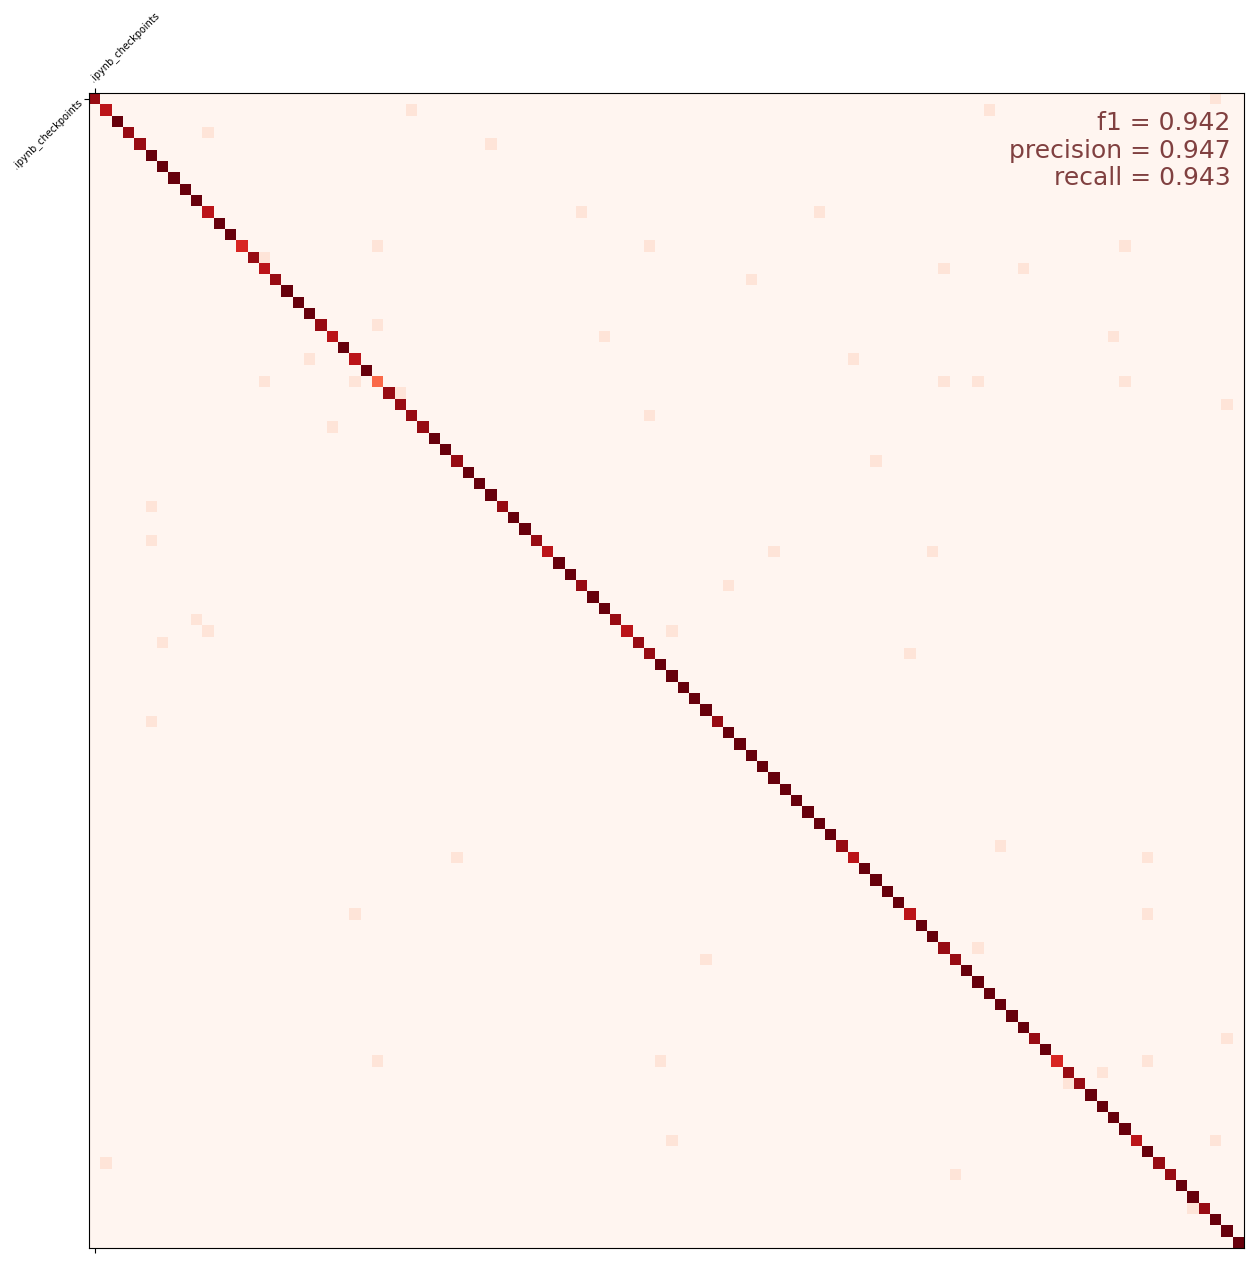

In [91]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Calculate confusion matrix
y_true = [label for _, _, label in predictions]
y_pred = [pred for _, pred, _ in predictions]

cmat = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

# Display confusion matrix
def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(dataset.classes)))
    ax.set_xticklabels(dataset.classes, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(dataset.classes)))
    ax.set_yticklabels(dataset.classes, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()

display_confusion_matrix(cmat, f1, precision, recall)
